In [45]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from scipy import stats

In [3]:
df = pd.read_excel("/Users/danilalipatov/Downloads/0_Тест_нефин_all_ред310125.xlsx", sheet_name='Ratings', skiprows=7)


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [295]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
date_features = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()


In [297]:
df = df[df["skip_качество данных"] == 0]
df['report_date'] = pd.to_datetime(df['report_date'])
df = df.sort_values(['global_id_ogrn','report_date'])
group_col = "global_id_ogrn"
date_col = "report_date"
feature = 'bosk'
y = df[feature]

In [299]:
df["log_Капитал"] = np.log(df["Капитал"])


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [301]:
# from scipy import stats

# def winsorize_series(series, limits=[0.01, 0.99]):
#     return stats.mstats.winsorize(series, limits=limits)

# df["Обслуживание_долга_win"] = winsorize_series(df["Обслуживание долга_OIBDA_показатель"])

# Винзоризация финансовых показателей
financial_ratios = [
    'Обслуживание долга_OIBDA_показатель',
    'Долговая нагрузка_OIBDA_показатель', 
    'Рентабельность по OIBDA_показатель'
]

for ratio in financial_ratios:
    if ratio in df.columns:
        df[f'{ratio}_win'] = stats.mstats.winsorize(
            df[ratio].fillna(df[ratio].median()), 
            limits=[0.01, 0.01]
        )

In [303]:
model_feats = [
    'log_Капитал',
    'Обслуживание долга_OIBDA_показатель_win', 
    'Долговая нагрузка_OIBDA_показатель_win'
]

In [321]:
df_model = df.dropna(subset=[feature]).copy()
df[model_feats] = df[model_feats].fillna(0).reset_index(drop=True).values
X = df_model[model_feats]
maps_ = {'aaa': 'aaa', 'aa+':
         'aa', 'aa': 'aa', 'aa-': 'aa', 
         'a+': 'a', 'a': 'a', 'a-': 'a', 
         'bbb+':'bbb', 'bbb':'bbb', 'bbb-': 'bbb', 
         'bb+':'bb', 'bb': 'bb', 'bb-':'bb',
         'b+':'b', 'b':'b', 'b-': 'b',
         'ccc':'ccc'}
maps_num = {'aaa': 0, 'aa+': 1,
         'aa': 1, 'aa-':1, 
         'a+': 2, 'a': 2, 'a-': 2, 
         'bbb+': 3, 'bbb':3, 'bbb-': 3, 
         'bb+': 4, 'bb': 4, 'bb-': 4,
         'b+': 5, 'b':5, 'b-': 5,
         'ccc':6}

rating_mapping = {
    'aaa': 21, 'aa+': 20, 'aa': 19, 'aa-': 18,
    'a+': 17, 'a': 16, 'a-': 15, 
    'bbb+': 14, 'bbb': 13, 'bbb-': 12,
    'bb+': 11, 'bb': 10, 'bb-': 9,
    'b+': 8, 'b': 7, 'b-': 6,
    'ccc': 5
}

maps_num_big = {'aaa': 1, 'aa+': 1,
         'aa': 1, 'aa': 1, 'aa-':1, 
         'a+': 2, 'a': 2, 'a-': 2, 
         'bbb+': 2, 'bbb':2, 'bbb-': 2, 
         'bb+': 3, 'bb': 3, 'bb-': 3,
         'b+': 3, 'b':3, 'b-': 3,
         'ccc':3}

y = df_model[feature].map(rating_mapping)
# y = df_model[feature]
# y = df_model[feature] 
y.unique()
for col in model_feats:
    X[col] = X[col].fillna(0)

/var/folders/0w/pg719rr9519435t25t6yf2hm0000gn/T/ipykernel_21042/2544896287.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(0)


In [323]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, model_feats)
    ]
)

In [325]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# CART модель с глубиной 3 (как в статье для монотонных моделей)
cart_model = DecisionTreeClassifier(
    max_depth=3,  # ФИКСИРОВАННАЯ ГЛУБИНА как в статье
    random_state=42
)

# SVR модель (для сравнения)
svr_regressor = SVR(kernel='rbf')

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),  # только на тренировке
    ("classifier", cart_model)  # используем одну CART модель с глубиной 3
])


In [327]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # stratify для классификации
)


In [329]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def calculate_notch_accuracy(y_true, y_pred):
    """
    Notch-distance accuracy как в статье:
    - d ≤ 0.5: расстояние = 0 (точное попадание)
    - 0.5 < d ≤ 1.5: расстояние = 1 (погрешность в одну "ноту") 
    - d > 1.5: считается ошибкой
    """
    errors = np.abs(y_true - y_pred)
    accurate = np.sum(errors <= 0.5)
    one_notch = np.sum((errors > 0.5) & (errors <= 1.5))
    acc = (accurate + 0.5 * one_notch) / len(y_true)
    return acc

def evaluate_article_metrics(y_true, y_pred):
    """Все метрики из статьи"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    acc = calculate_notch_accuracy(y_true, y_pred)
    
    return {
        'R2': round(r2, 4),
        'RMSE': round(rmse, 4),
        'ACC': round(acc, 4)
    }

In [331]:
pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)

# Оценка качества
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.16747967479674797

Classification Report:
              precision    recall  f1-score   support

           5       0.10      0.40      0.16         5
           6       0.07      0.30      0.12        10
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        34
          10       0.11      0.54      0.19        41
          11       0.00      0.00      0.00        52
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00        56
          14       0.00      0.00      0.00        64
          15       0.19      0.68      0.30        59
          16       0.13      0.08      0.10        48
          17       0.00      0.00      0.00        38
          18       0.00      0.00      0.00        45
          19       0.21      0.85      0.33        26
          20       0.00      0.00      0.00        24
          21       0.71    

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [333]:
# Оценка по метрикам из статьи
metrics = evaluate_article_metrics(y_test, y_pred)

print("=" * 50)
print("ОЦЕНКА ПО МЕТРИКАМ ИЗ СТАТЬИ")
print("=" * 50)
print(f"R² (коэффициент детерминации): {metrics['R2']}")
print(f"RMSE (среднеквадратичная ошибка): {metrics['RMSE']}")
print(f"ACC (notch-distance accuracy): {metrics['ACC']}")
print("=" * 50)

ОЦЕНКА ПО МЕТРИКАМ ИЗ СТАТЬИ
R² (коэффициент детерминации): 0.5508
RMSE (среднеквадратичная ошибка): 2.5024
ACC (notch-distance accuracy): 0.326


In [335]:
print("\nДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК:")
errors = np.abs(y_test - y_pred)
perfect = np.sum(errors <= 0.5)

print(f"Точное попадание (d ≤ 0.5): {perfect}/{len(y_test)} ({perfect/len(y_test)*100:.1f}%)")


ДЕТАЛЬНЫЙ АНАЛИЗ ОШИБОК:
Точное попадание (d ≤ 0.5): 103/615 (16.7%)


ВАЖНОСТЬ ПРИЗНАКОВ В CART МОДЕЛИ:
log_Капитал: 0.6020
Обслуживание долга_OIBDA_показатель_win: 0.3206
Долговая нагрузка_OIBDA_показатель_win: 0.0774


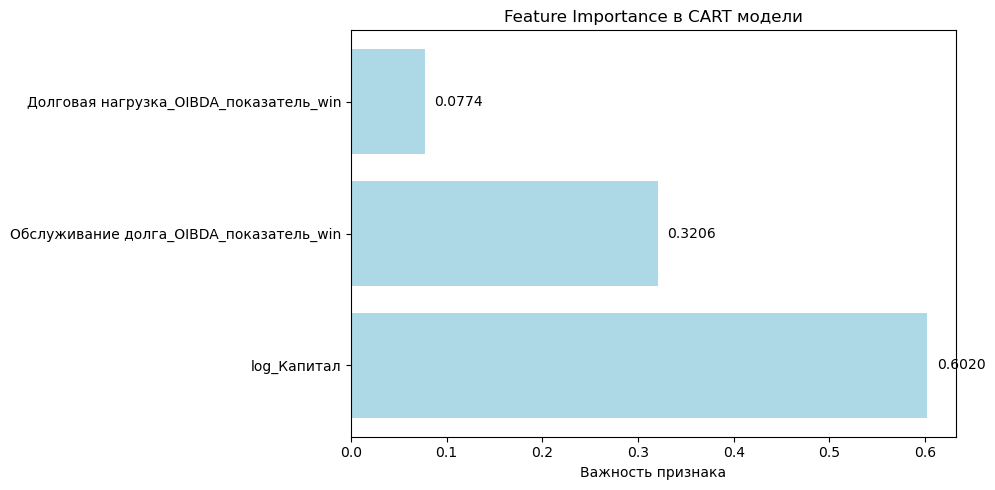

In [337]:
# Получаем важность признаков из пайплайна
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Получаем названия признаков после препроцессинга
feature_names = model_feats  # используем те же features что в препроцессоре

print("ВАЖНОСТЬ ПРИЗНАКОВ В CART МОДЕЛИ:")
print("=" * 40)

for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance:.4f}")

# Визуализация
plt.figure(figsize=(10, 5))
bars = plt.barh(feature_names, feature_importance, color='lightblue')
plt.xlabel('Важность признака')
plt.title('Feature Importance в CART модели')

# Добавляем значения
for bar, imp in zip(bars, feature_importance):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{imp:.4f}', va='center')

plt.tight_layout()
plt.show()

In [216]:
# Пайплайн для SVR
pipeline_svr = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", svr_regressor)
])

# Обучение SVR
pipeline_svr.fit(X_train, y_train)
y_pred_svr = pipeline_svr.predict(X_test)
metrics_svr = evaluate_article_metrics(y_test, y_pred_svr)

print("\n" + "=" * 50)
print("СРАВНЕНИЕ CART vs SVR (как в статье)")
print("=" * 50)
print(f"{'Метрика':<10} | {'CART (depth=3)':<15} | {'SVR':<15}")
print(f"{'R²':<10} | {metrics['R2']:<15} | {metrics_svr['R2']:<15}")
print(f"{'RMSE':<10} | {metrics['RMSE']:<15} | {metrics_svr['RMSE']:<15}")
print(f"{'ACC':<10} | {metrics['ACC']:<15} | {metrics_svr['ACC']:<15}")
print("=" * 50)


СРАВНЕНИЕ CART vs SVR (как в статье)
Метрика    | CART (depth=3)  | SVR            
R²         | 0.2855          | 0.4492         
RMSE       | 0.5774          | 0.5069         
ACC        | 0.8333          | 0.8293         


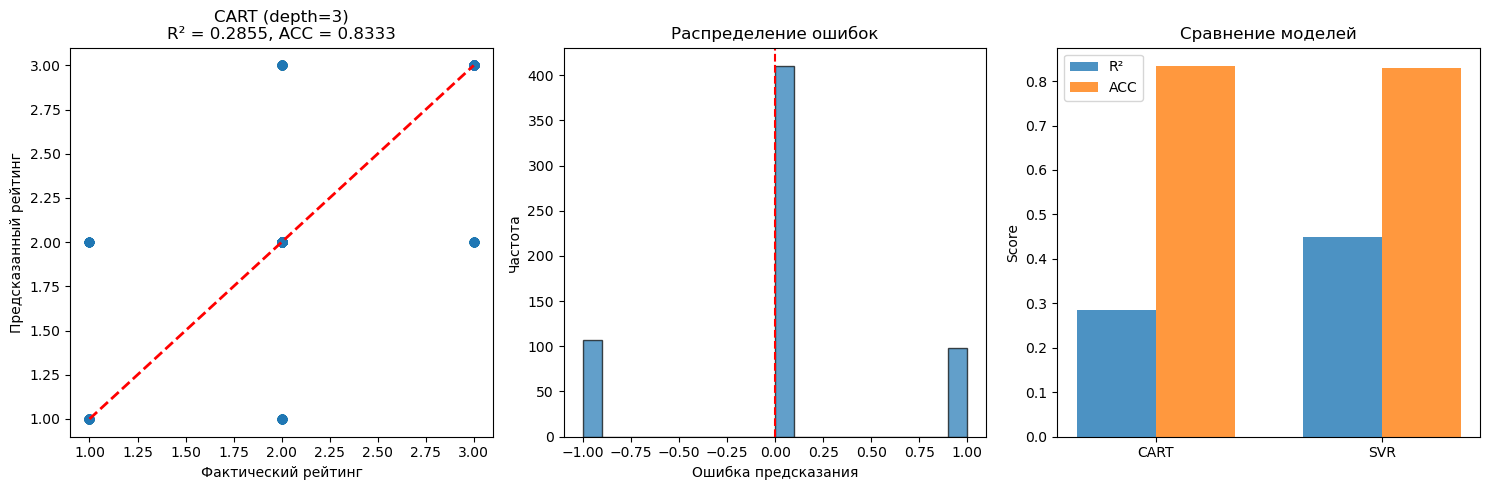

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Сравнение метрик
plt.subplot(1, 3, 3)
models = ['CART', 'SVR']
r2_scores = [metrics['R2'], metrics_svr['R2']]
acc_scores = [metrics['ACC'], metrics_svr['ACC']]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, r2_scores, width, label='R²', alpha=0.8)
plt.bar(x + width/2, acc_scores, width, label='ACC', alpha=0.8)
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Сравнение моделей')
plt.legend()

plt.tight_layout()
plt.show()